# Problem Definition

The mobile game "Cookie Cats" is a freenium game where users can play for free but are asked to make in-app purchases to improve their in-game experience. This notebook explores the effect of an A/B test—moving the first user "gate" from level 30 to level 40—on player retention.

# Data Exploration

In [1]:
import pandas as pd

In [3]:
df = pd.read_csv('data/cookie_cats.csv')

In [6]:
df.head()

,userid,version,sum_gamerounds,retention_1,retention_7
0,116,gate_30,3,False,False
1,337,gate_30,38,True,False
2,377,gate_40,165,True,False
3,483,gate_40,1,False,False
4,488,gate_40,179,True,True


In [56]:
df.shape

(90189, 5)

In [30]:
df.dtypes

userid             int64
version           object
sum_gamerounds     int64
retention_1         bool
retention_7         bool
dtype: object

## Understanding the Features

Our two groups can be identified by the field "version," while our target is retention_7

- **version:** Whether the player was put in the control group (gate_30 - a gate at level 30) or the group with the moved gate (gate_40 - a gate at level 40).
- **sum_gamerounds:** The number of game rounds played by the player during the first 14 days after install.
- **retention_1:** Did the player come back and play 1 day after installing?
- **retention_7:** Did the player come back and play 7 days after installing?

In [32]:
df.describe(include='all')

,userid,version,sum_gamerounds,retention_1,retention_7
count,9.018900e+04,90189,90189.000000,90189,90189
unique,NaN,2,NaN,2,2
top,NaN,gate_40,NaN,False,False
freq,NaN,45489,NaN,50036,73408
mean,4.998412e+06,NaN,51.872457,NaN,NaN
std,2.883286e+06,NaN,195.050858,NaN,NaN
min,1.160000e+02,NaN,0.000000,NaN,NaN
25%,2.512230e+06,NaN,5.000000,NaN,NaN
50%,4.995815e+06,NaN,16.000000,NaN,NaN
75%,7.496452e+06,NaN,51.000000,NaN,NaN


### Confirming Random Assignment Using Kolmogorov-Smirnov 2 Sample Test

In [10]:
# split the dataset into a and b groups
# so we can confirm random assignment
a = df[df['version'] == 'gate_30']
b = df[df['version'] == 'gate_40']

In [34]:
from scipy.stats import ks_2samp
import numpy as np

In [36]:
ks_2samp(a.sum_gamerounds, b.sum_gamerounds)

Ks_2sampResult(statistic=0.010270735856046653, pvalue=0.017190150793918755)

### Were the A/B Groups Truly Random?

Given the p-value = 1.72%, there is a 1.72% change that these 2 samples came from the same population given the difference in distributions of the number of rounds played. While this can indicate that our users were not properly bucketed into sample groups, if the groups were chosen at player sign-up this can be a side-effect of our intervention. 

Unfortunately, it looks like we can't confirm with certainty that our random assignment was truly random. For now, we will continue under the assumption that any differences in samples we observe—including in the sum_gamerounds feature—is a function of our intervention.

## Exploratory Data Analysis

In [38]:
import seaborn as sns
import matplotlib.pyplot as plt

In [50]:
# Summary statistics by A/B group
df.groupby('version').mean()

,userid,sum_gamerounds,retention_1,retention_7
version,,,,
gate_30,4.987564e+06,52.456264,0.448188,0.190201
gate_40,5.009073e+06,51.298776,0.442283,0.182000


While intuitively we would expect retention to be better if users hit a paywall gate later rather than earlier, the summary statistics point to a different story. The users with a gate at an earlier level (level 30) played slightly more rounds (52.4 vs 51.2), were more likely to play on the first day (44.8% vs 44.2%) and more likely to continue playing to the 7th day (19% vs 18.2%). 

*How significant are the differences, and how big is the power of our results?*

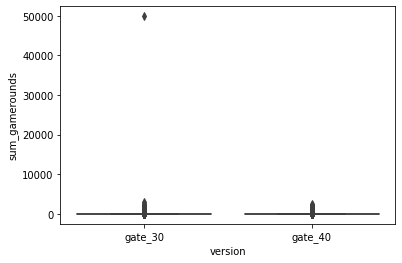

In [52]:
sns.boxplot(data=df, x='version', y='sum_gamerounds')
plt.show()

We have a major outlier in Group A, with 49,854 total rounds played. Given how extreme this data point is, this appears to be a data error. Excluding it would be best

In [62]:
print(len(df[df['sum_gamerounds'] < 10000])) # number of data points after excluding outliers
df = df[df['sum_gamerounds'] < 10000]
a = a[a['sum_gamerounds'] < 10000]

90188


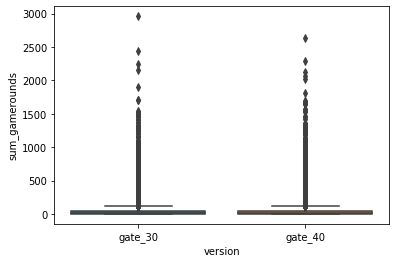

In [63]:
sns.boxplot(data=df, x='version', y='sum_gamerounds')
plt.show()

While we still have a lot of outliers—a handful of people who play 500+ rounds—this distribution makes more sense.

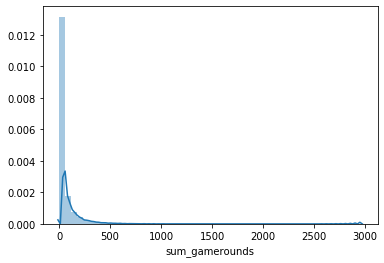

In [64]:
# Distribution is highly skewed to the right, making this distribution
# difficult to analyze
sns.distplot(df['sum_gamerounds']);

In [46]:
# Identifying how many datapoints will be covered
# if we only show the first 50 rounds
round(len(a[a['sum_gamerounds'] < 50]) / len(a),2)

0.75

### Distribution of Total Game Rounds Played, By A/B Group

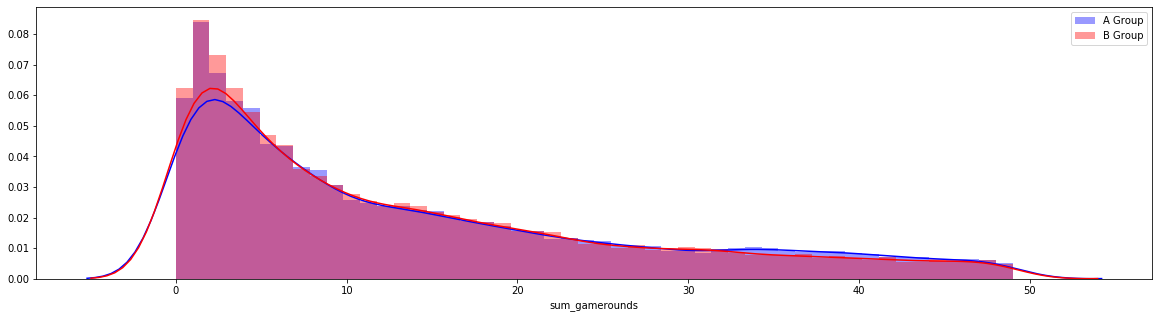

In [47]:
plt.figure(figsize=(20,5))
sns.distplot(a[a['sum_gamerounds'] < 50]['sum_gamerounds'], label='A Group', bins=50, color='blue')
sns.distplot(b[b['sum_gamerounds'] < 50]['sum_gamerounds'], label='B Group', bins=50, color='red')
plt.legend()
plt.show()

We can see that the two user groups are very similar in the number of rounds they played. There is a small bump in the probability that the users played, in total, 32-40 game rounds for Group A. This seems counterintuitive, since Group A still had the gate at round 30 and Group B would've been able to play rounds 30-39 without any interference.

## Analyzing 1 Day Retention

In [68]:
# Summary statistics of 1 Day Retention by A/B group
df.groupby('version').mean()['retention_1']

version
gate_30    0.448198
gate_40    0.442283
Name: retention_1, dtype: float64

In [69]:
df['retention_1'].mean()

0.4452144409455803

In order to get an idea of the difference in the average 1D retention rate between our A and B groups, we will bootstrap each group and obtain a distribution of sample means, allowing us to calculate a sample statistic.

In [100]:
boot_1d = []
iterations = 1000
n = 500

for i in range(iterations):
    sample_mean = df.sample(frac=0.2, replace=True).groupby('version')['retention_1'].mean() # calculate sample means
    boot_1d.append(sample_mean)
boot_1d_df = pd.DataFrame(boot_1d)

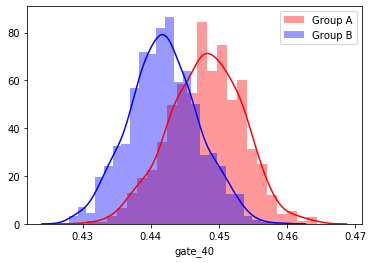

In [105]:
sns.distplot(boot_1d_df['gate_30'], color='red', label='Group A')
sns.distplot(boot_1d_df['gate_40'], color='blue', label='Group B')
plt.legend()
plt.show()

In [106]:
boot_1d_df.mean()

version
gate_30    0.448046
gate_40    0.441878
dtype: float64

We will use an independent samples t-test to determine if the difference in mean 1D retention between groups is the same
H0: The mean 1D retention rates (%) are the same for both Group A (initial gate at level 30) and Group B (level 40)
Ha: The means 1D retention rates (%) are different

In [107]:
boot_1d_df.head()

version,gate_30,gate_40
retention_1,0.450644,0.439024
retention_1,0.453324,0.451102
retention_1,0.449596,0.445126
retention_1,0.447187,0.444215
retention_1,0.446140,0.437700


In [108]:
a_sample_means = boot_1d_df['gate_30']
b_sample_means = boot_1d_df['gate_40']

In [109]:
from scipy import stats
t2, p2 = stats.ttest_ind(a_sample_means,b_sample_means)
print("t = " + str(t2))
print("p = " + str(p2))

t = 26.3084409597211
p = 3.136848049764881e-131


While we can reject the null hypothesis that there is no difference in retention rates between groups, what is the power of the test?

*Is this difference large enough to be of significance to us (and affect our business decisions)?*

In [111]:
## Investigate Power

## Analyzing 7 Day Retention

In [112]:
# Summary statistics of 1 Day Retention by A/B group
df.groupby('version').mean()['retention_7']

version
gate_30    0.190183
gate_40    0.182000
Name: retention_7, dtype: float64

In [113]:
df['retention_7'].mean()

0.1860557945624695

Again, we are bootstrapping to compare the sample means of our two samples.

In [115]:
boot_7d = []
iterations = 1000

for i in range(iterations):
    sample_mean = df.sample(frac=0.2, replace=True).groupby('version')['retention_7'].mean() # calculate sample means
    boot_7d.append(sample_mean)
boot_7d_df = pd.DataFrame(boot_1d)

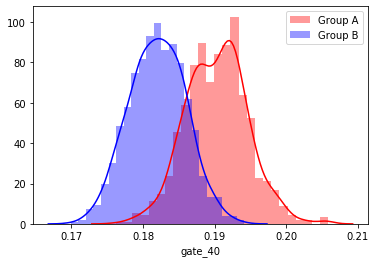

In [116]:
sns.distplot(boot_7d_df['gate_30'], color='red', label='Group A')
sns.distplot(boot_7d_df['gate_40'], color='blue', label='Group B')
plt.legend()
plt.show()

In [117]:
boot_7d_df.mean()

version
gate_30    0.190298
gate_40    0.182000
dtype: float64

In [118]:
a_sample_means = boot_7d_df['gate_30']
b_sample_means = boot_7d_df['gate_40']

In [119]:
from scipy import stats
t2, p2 = stats.ttest_ind(a_sample_means,b_sample_means)
print("t = " + str(t2))
print("p = " + str(p2))

t = 44.88543470517819
p = 7.284100791781645e-305


Similarly, we can reject the null hypothesis that there is no difference in 7 day retention rates between groups.

## Conclusion

We were able to prove that moving the gate from level 30 to level 40 actually decreases retainment. So, counterintuitively, forcing users to either pay or wait a nominal amount of time before continuing to play *earlier rather than later* increases enjoyment and encourages people to play more often.